In [2]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import multi_rake
import re
import string
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from multi_rake import Rake
import nltk
import csv
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
#nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize, pos_tag

In [3]:
BB = pd.read_csv('/Users/jiaruizhang/Desktop/reviews/coding/after sort.csv')
BB = BB.sort_index()
BB

,content,star,sku,label
0,its a bagit holds candy not included trick or ...,5,8566349,1
1,the bag would be a great deal if it was availa...,1,8566349,0
2,loved the movie and it played ok was delivered...,5,6083463,1
3,as a guy i cant say im headoverheels for dirty...,3,6083463,0
4,this movie is great for all ages shipping was ...,5,8977805,1
...,...,...,...,...
154,i bought this as a christmas gift for a family...,5,3792604,0
155,our purchase was as a christmas gift for our g...,5,3792604,1
156,this is just a quick note for anyone who was c...,4,3792604,1
157,stargate sg the entire series just amazing to ...,5,8553399,0


In [4]:
product = BB.sku.nunique()
occur = BB.groupby('sku').count()
occur.label.max()

7

In [5]:
from nltk import FreqDist
import seaborn as sns
def clean_text_r3(text):
    tokenizer = nltk.tokenize.TreebankWordTokenizer()
    tokens = tokenizer.tokenize(text)
    stemmer = nltk.stem.WordNetLemmatizer()
    text = " ".join(stemmer.lemmatize(token)for token in tokens)
    return text
round3 = lambda x: clean_text_r3(x)
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    return d

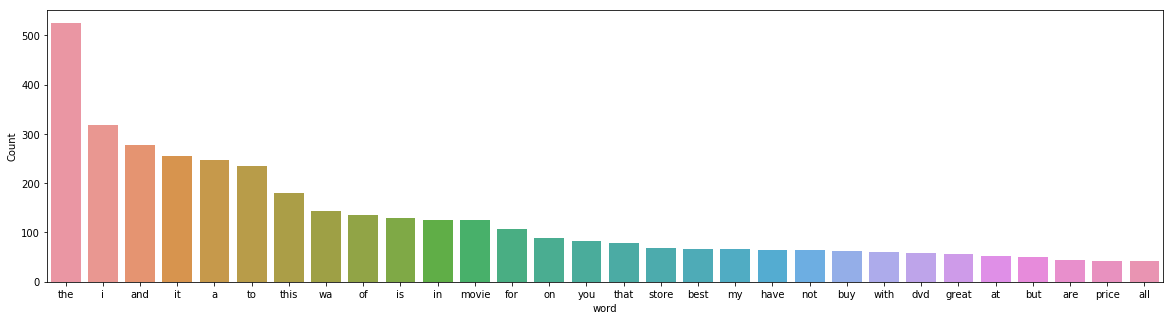

,word,count
29,the,525
51,i,319
63,and,277
0,it,256
1,a,247
26,to,235
13,this,181
35,wa,144
42,of,135
45,is,129


In [6]:
BB['content'] = pd.DataFrame(BB.content.apply(round3))
freq_words(BB['content'])

In [7]:
BB

,content,star,sku,label
0,it a bagit hold candy not included trick or tr...,5,8566349,1
1,the bag would be a great deal if it wa availab...,1,8566349,0
2,loved the movie and it played ok wa delivered ...,5,6083463,1
3,a a guy i cant say im headoverheels for dirty ...,3,6083463,0
4,this movie is great for all age shipping wa ex...,5,8977805,1
...,...,...,...,...
154,i bought this a a christmas gift for a family ...,5,3792604,0
155,our purchase wa a a christmas gift for our gra...,5,3792604,1
156,this is just a quick note for anyone who wa co...,4,3792604,1
157,stargate sg the entire series just amazing to ...,5,8553399,0


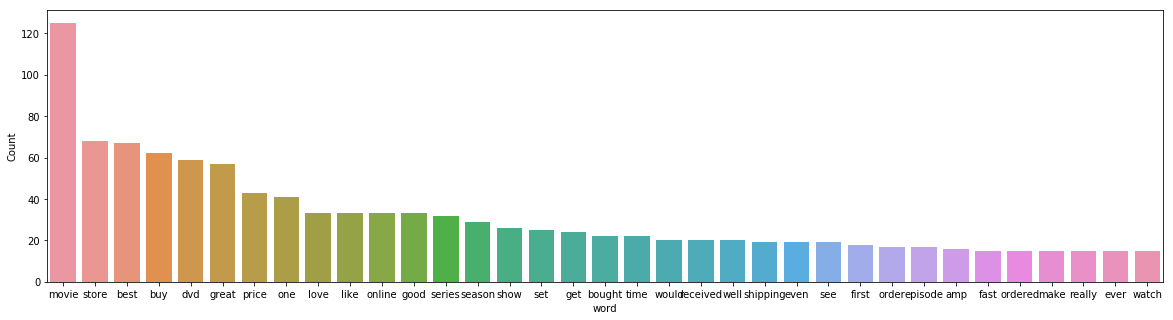

,word,count
37,movie,125
23,store,68
69,best,67
70,buy,62
59,dvd,59
20,great,57
26,price,43
7,one,41
50,love,33
217,like,33


In [8]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new
# remove short words (length < 3)
BB['content'] = BB['content'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
# remove stopwords from the text
overall_reviews = [remove_stopwords(r.split()) for r in BB['content']]
freq_words(overall_reviews, 35)
# To further remove noise from the text we can use lemmatization from the spaCy library. 
# It reduces any given word to its base form thereby reducing multiple forms of a word to a single word.

In [10]:
import spacy
import gensim
from gensim import corpora
# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
tokenized_overall = pd.Series(overall_reviews).apply(lambda x: x.split())
dictionary = corpora.Dictionary(tokenized_overall)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_overall]
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel
# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=5, random_state=100,
                chunksize=1000, passes=50)
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model,corpus=doc_term_matrix, texts=tokenized_overall,coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
import numpy as np
import tqdm


Coherence Score:  0.20973066880886088


In [8]:

# supporting function
corpus=doc_term_matrix
id2word=dictionary
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=doc_term_matrix, id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model,corpus=doc_term_matrix, texts=tokenized_overall,coherence='c_v')
    
    return coherence_model_lda.get_coherence()
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.1))
# Beta parameter
beta = list(np.arange(0.01, 1, 0.1))
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=1600)
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_overall.csv', index=False)
    pbar.close()

100%|██████████| 1600/1600 [28:38<00:00,  1.07s/it]


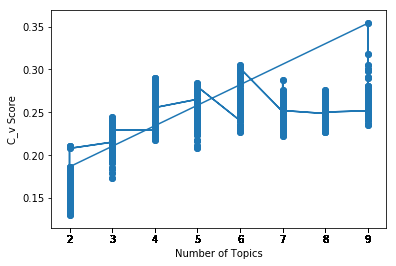

In [22]:
# filter the results
results_for_vis = pd.read_csv("lda_tuning_results_overall.csv")
#results_for_vis = results[results["Alpha"]!='symmetric']
#results_for_vis = results_for_vis[results_for_vis["Alpha"]!='asymmetric']
#results_for_vis = results_for_vis[results_for_vis["Beta"]!='symmetric']
#results_for_vis = results_for_vis[results_for_vis["Beta"]!='asymmetric']

# now the plot
import matplotlib.pyplot as plt
plt.plot(np.array(results_for_vis["Topics"]), np.array(results_for_vis["Coherence"]))
plt.scatter(np.array(results_for_vis["Topics"]), np.array(results_for_vis["Coherence"]))
plt.ylabel("C_v Score")
plt.xlabel("Number of Topics")
plt.xticks(np.array(results_for_vis["Topics"]))
plt.show()

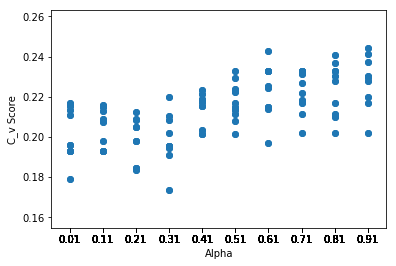

In [24]:
results_for_vis = results_for_vis[results_for_vis["Topics"]==3]
#results_for_vis = results_for_vis[results_for_vis["Alpha"]!='asymmetric']
#results_for_vis = results_for_vis[results_for_vis["Beta"]!='asymmetric']

# now the plot
import matplotlib.pyplot as plt
#plt.plot(np.array(results_for_vis["Alpha"]), np.array(results_for_vis["Coherence"]))
plt.scatter(np.array(results_for_vis["Alpha"]), np.array(results_for_vis["Coherence"]))
plt.ylabel("C_v Score")
plt.xlabel("Alpha")
plt.xticks(np.array(results_for_vis["Alpha"]))
plt.show()
# 0.81 0.91

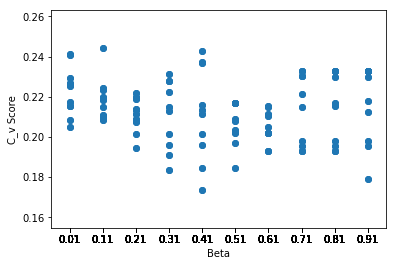

In [4]:
results_for_vis = pd.read_csv("lda_tuning_results_overall.csv")
results_for_vis = results_for_vis[results_for_vis["Topics"]==3]
#results_for_vis = results_for_vis[results_for_vis["Alpha"]!='asymmetric']
#results_for_vis = results_for_vis[results_for_vis["Beta"]!='symmetric']
#results_for_vis = results_for_vis[results_for_vis["Beta"]=='0.61']

# now the plot
import matplotlib.pyplot as plt
#plt.plot(np.array(results_for_vis["Beta"]), np.array(results_for_vis["Coherence"]))
plt.scatter(np.array(results_for_vis["Beta"]), np.array(results_for_vis["Coherence"]))
plt.ylabel("C_v Score")
plt.xlabel("Beta")
plt.xticks(np.array(results_for_vis["Beta"]))
plt.show()
#0.81 0.91

In [11]:
# k = 3, a = b = 0.81

# supporting function
corpus=doc_term_matrix
id2word=dictionary
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.61,
                                           eta=0.41)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis
pyLDAvis.save_html(vis, 'BB_overall_sep_3.html')

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [12]:
BB

,content,star,sku,label
0,bagit hold candy not included trick treat you ...,5,8566349,1
1,the bag would great deal available for store p...,1,8566349,0
2,loved the movie and played delivered ontime,5,6083463,1
3,guy cant say headoverheels for dirty dancing b...,3,6083463,0
4,this movie great for all age shipping extremel...,5,8977805,1
...,...,...,...,...
154,bought this christmas gift for family with fou...,5,3792604,0
155,our purchase christmas gift for our granddaugh...,5,3792604,1
156,this just quick note for anyone who concerned ...,4,3792604,1
157,stargate the entire series just amazing able w...,5,8553399,0


In [13]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model,corpus=doc_term_matrix, texts=tokenized_overall,coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.2428341521104599


In [30]:
corpus=doc_term_matrix
id2word=dictionary
model_cnt = [0,0,0]
temp_1,temp_2,temp_3 = 0, 0, 0
cnt = 0
for i in range(len(overall_reviews)):
    corpus_1= [id2word.doc2bow(word_tokenize(overall_reviews[i]))]
    temp_model = lda_model.get_document_topics(corpus_1,minimum_probability=1e-4)
    if (len(temp_model[0])>2):
        temp_1 += temp_model[0][0][1]
        temp_2 += temp_model[0][1][1]
        temp_3 += temp_model[0][2][1]
        cnt += 1
    else:
        print(i)        
model_cnt[0] = temp_1/cnt # topic 1
model_cnt[1] = temp_2/cnt # topic 2
model_cnt[2] = temp_3/cnt # topic 3        

In [31]:
len(overall_reviews)

159

In [25]:
corpus_1= [id2word.doc2bow(word_tokenize(overall_reviews[132]))]
temp_model = lda_model[corpus_1]
print(overall_reviews[132])
for topic in temp_model:
    print(topic)

first dear best buy youve got dvd content wrong disk doe contain episode featuring afterworld tournament saiyaman sagabr contains quotcell returnsquot horror wont end save world gokus decision one wish free future doe contain episode list description cell returnsquot folk picky sort thing fan buying disk dedicated series want know theyre buyingbr second thanks lovely lady best buy honored competitor price wasnt aware given proof lower price best buy would indeed honor competitor price guy rockbr onto disk new set excellent upgrade originally aired episode season six exception theyre uncut restored remasteredand bonusuthe disk contain original toonami run dbz well japanese language edition many company willing include three version product theyve edit order meet american television guideline original japanese product theyve worked nice see company make effort please fan tasteswhile many adult otaku appreciate uncutrestored edition parent appreciate edited version younger uncorrupted fan

In [32]:
sum(model_cnt)

1.0000075752811752

In [28]:
BB

,content,star,sku,label
0,bagit hold candy not included trick treat you ...,5,8566349,1
1,the bag would great deal available for store p...,1,8566349,0
2,loved the movie and played delivered ontime,5,6083463,1
3,guy cant say headoverheels for dirty dancing b...,3,6083463,0
4,this movie great for all age shipping extremel...,5,8977805,1
...,...,...,...,...
154,bought this christmas gift for family with fou...,5,3792604,0
155,our purchase christmas gift for our granddaugh...,5,3792604,1
156,this just quick note for anyone who concerned ...,4,3792604,1
157,stargate the entire series just amazing able w...,5,8553399,0


In [14]:
BB['topic 0'] = 0
BB['topic 1'] = np.nan
BB['topic 2'] = np.nan
BB['topic 3'] = np.nan
for i in range(len(overall_reviews)):
    corpus_1= [id2word.doc2bow(word_tokenize(overall_reviews[i]))]
    temp_model = lda_model.get_document_topics(corpus_1,minimum_probability=1e-4)
    BB.at[i, 'topic 1'] = temp_model[0][0][1]
    BB.at[i, 'topic 2'] = temp_model[0][1][1]
    BB.at[i, 'topic 3'] = temp_model[0][2][1]
BB

,content,star,sku,label,topic 0,topic 1,topic 2,topic 3
0,bagit hold candy not included trick treat you ...,5,8566349,1,0,0.035076,0.038941,0.925987
1,the bag would great deal available for store p...,1,8566349,0,0,0.031136,0.926000,0.042885
2,loved the movie and played delivered ontime,5,6083463,1,0,0.533636,0.219605,0.246712
3,guy cant say headoverheels for dirty dancing b...,3,6083463,0,0,0.032270,0.937522,0.030212
4,this movie great for all age shipping extremel...,5,8977805,1,0,0.097499,0.174463,0.728103
...,...,...,...,...,...,...,...,...
154,bought this christmas gift for family with fou...,5,3792604,0,0,0.018154,0.953994,0.027857
155,our purchase christmas gift for our granddaugh...,5,3792604,1,0,0.023886,0.949697,0.026427
156,this just quick note for anyone who concerned ...,4,3792604,1,0,0.049815,0.888806,0.061348
157,stargate the entire series just amazing able w...,5,8553399,0,0,0.024106,0.950166,0.025714


In [15]:
# The y values.  A numpy array is used here,
# but a python list could also be used.
fair_y = [0,0.333333,0.333333,0.333333]
fair_y_cum = np.cumsum(fair_y)
fair_area = np.trapz(fair_y_cum, dx=4)
BB['area'] = np.nan
BB['GINI coe'] = np.nan
for i in range(len(overall_reviews)):
    if i != 132:
        y = []
        for j in range(4):
            temp = 'topic '+str(j)
            y.append(BB.at[i,temp])
            # [0, 0.0532762, 0.06006141, 0.8866621]
        y_cum = np.cumsum(y)
        # [0.  0.05327629 0.11333771 0.99999983]
        BBarea = np.trapz(y_cum, dx=4)
        BB.at[i, 'area'] = BBarea
        BB.at[i, 'GINI coe'] = (fair_area - BBarea)/fair_area
        
BB

,content,star,sku,label,topic 0,topic 1,topic 2,topic 3,area,GINI coe
0,bagit hold candy not included trick treat you ...,5,8566349,1,0,0.035076,0.038941,0.925987,2.436382,0.593936
1,the bag would great deal available for store p...,1,8566349,0,0,0.031136,0.926000,0.042885,5.953133,0.007810
2,loved the movie and played delivered ontime,5,6083463,1,0,0.533636,0.219605,0.246712,7.147409,-0.191236
3,guy cant say headoverheels for dirty dancing b...,3,6083463,0,0,0.032270,0.937522,0.030212,6.008256,-0.001377
4,this movie great for all age shipping extremel...,5,8977805,1,0,0.097499,0.174463,0.728103,3.477978,0.420336
...,...,...,...,...,...,...,...,...,...,...
154,bought this christmas gift for family with fou...,5,3792604,0,0,0.018154,0.953994,0.027857,5.961216,0.006463
155,our purchase christmas gift for our granddaugh...,5,3792604,1,0,0.023886,0.949697,0.026427,5.989891,0.001684
156,this just quick note for anyone who concerned ...,4,3792604,1,0,0.049815,0.888806,0.061348,5.953688,0.007718
157,stargate the entire series just amazing able w...,5,8553399,0,0,0.024106,0.950166,0.025714,5.993484,0.001085


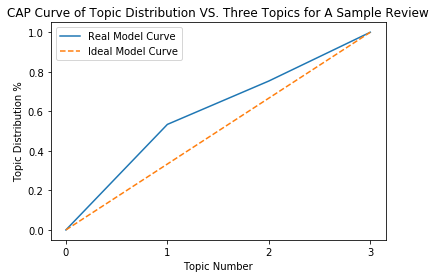

In [44]:
corpus_1= [id2word.doc2bow(word_tokenize(overall_reviews[2]))]
temp_model = lda_model[corpus_1]
y = [0,0,0,0]
x = [0,1,2,3]
yh = [0,0.3333333,0.66666666,1]
y[1] = temp_model[0][0][1]
y[2] = temp_model[0][1][1]
y[3] = temp_model[0][2][1]
fair_y_cum = np.cumsum(y)
plt.plot(x,fair_y_cum,'-',x,yh,'--')
plt.legend(["Real Model Curve","Ideal Model Curve"])
#fair_area = np.trapz(fair_y_cum, dx=4)
plt.ylabel("Topic Distribution %")
plt.xlabel("Topic Number")
plt.title("CAP Curve of Topic Distribution VS. Three Topics for A Sample Review")
plt.xticks(np.arange(0, 4, step=1))
plt.show()


In [18]:
import statistics as sta
np.mean(BB['GINI coe'])

0.09159707895169805

In [16]:
online = BB[BB.label==1] #83 rows
store = BB[BB.label==0] # 76 rows
store = store.reset_index()
store = store.drop(columns=['index'])
store

,content,star,sku,label,topic 0,topic 1,topic 2,topic 3,area,GINI coe
0,the bag would great deal available for store p...,1,8566349,0,0,0.031136,0.926000,0.042885,5.953133,0.007810
1,guy cant say headoverheels for dirty dancing b...,3,6083463,0,0,0.032270,0.937522,0.030212,6.008256,-0.001377
2,ordered this dvd cyber mondaybr best buy where...,5,8977805,0,0,0.024979,0.952785,0.022238,6.010981,-0.001831
3,will continue order bestbuycom the movie not a...,4,3873909,0,0,0.081162,0.356197,0.562583,4.073965,0.321005
4,this movie not one would have typically checke...,5,1067784,0,0,0.948321,0.022399,0.029266,9.676142,-0.612692
...,...,...,...,...,...,...,...,...,...,...
71,this season babylon had the best season much h...,5,6074302,0,0,0.015393,0.968313,0.016303,5.996410,0.000597
72,thank goodness tnt advertised this being relea...,5,8700015,0,0,0.011008,0.978343,0.010643,6.001423,-0.000238
73,can just say quotits about timequot have been ...,5,8700015,0,0,0.021367,0.956504,0.022128,5.996947,0.000508
74,bought this christmas gift for family with fou...,5,3792604,0,0,0.018154,0.953994,0.027857,5.961216,0.006463


In [19]:
store_sku = [8946929,8534124,8829155,5998654,7865115,
             8399146,9325606,9325544,8811045,9658199,
             8700015]
store['norm_GINI'] = store['GINI coe']
for i in store_sku:
    temp = []
    pos = []
    for j in range(76):
        if store.loc[j].at['sku'] == i:
            temp.append(store.at[j,'GINI coe'])
            pos.append(j)
    mean = sta.mean(temp)
    m = 0
    for k in pos:
        store.at[k,"norm_GINI"] = mean
        m += 1    
store

,content,star,sku,label,topic 0,topic 1,topic 2,topic 3,area,GINI coe,norm_GINI
0,the bag would great deal available for store p...,1,8566349,0,0,0.031136,0.926000,0.042885,5.953133,0.007810,0.007810
1,guy cant say headoverheels for dirty dancing b...,3,6083463,0,0,0.032270,0.937522,0.030212,6.008256,-0.001377,-0.001377
2,ordered this dvd cyber mondaybr best buy where...,5,8977805,0,0,0.024979,0.952785,0.022238,6.010981,-0.001831,-0.001831
3,will continue order bestbuycom the movie not a...,4,3873909,0,0,0.081162,0.356197,0.562583,4.073965,0.321005,0.321005
4,this movie not one would have typically checke...,5,1067784,0,0,0.948321,0.022399,0.029266,9.676142,-0.612692,-0.612692
...,...,...,...,...,...,...,...,...,...,...,...
71,this season babylon had the best season much h...,5,6074302,0,0,0.015393,0.968313,0.016303,5.996410,0.000597,0.000597
72,thank goodness tnt advertised this being relea...,5,8700015,0,0,0.011008,0.978343,0.010643,6.001423,-0.000238,0.000135
73,can just say quotits about timequot have been ...,5,8700015,0,0,0.021367,0.956504,0.022128,5.996947,0.000508,0.000135
74,bought this christmas gift for family with fou...,5,3792604,0,0,0.018154,0.953994,0.027857,5.961216,0.006463,0.006463


In [20]:
# sorting by first name 
store.sort_values("sku", inplace=True) 
# dropping duplicate values 
store = store.drop_duplicates(subset='norm_GINI', keep='first')

In [21]:
store

,content,star,sku,label,topic 0,topic 1,topic 2,topic 3,area,GINI coe,norm_GINI
4,this movie not one would have typically checke...,5,1067784,0,0,0.948321,0.022399,0.029266,9.676142,-0.612692,-0.612692
70,vampire diary the complete first season christ...,5,1085331,0,0,0.024928,0.026098,0.948978,2.303823,0.616029,0.616029
63,the movie look stunning bluray and having the ...,5,1253546,0,0,0.017974,0.016054,0.965963,2.207986,0.632002,0.632002
12,for everyone whose life hit rock bottom they t...,4,3142306,0,0,0.009488,0.009899,0.980612,2.115502,0.647416,0.647416
23,bought online for when went store pickup the d...,5,3687406,0,0,0.074274,0.188624,0.737112,3.348715,0.441880,0.441880
...,...,...,...,...,...,...,...,...,...,...,...
69,easy ordering online then just stopping the st...,5,9460601,0,0,0.096388,0.101654,0.801966,3.177739,0.470376,0.470376
56,were excitedly awaiting the arrival this movie...,5,9506117,0,0,0.035719,0.038412,0.925871,2.439400,0.593433,0.593433
22,great movie best buy great seller loved that b...,5,9615274,0,0,0.088241,0.837365,0.074422,6.055446,-0.009242,-0.009242
61,this been great dvd set love the show the pric...,5,9658199,0,0,0.057740,0.881377,0.060874,5.987414,0.002097,-0.228978


In [22]:
online = BB[BB.label==1] #83 rows
online = BB[BB.label==1] #83 rows
online = online.reset_index()
online = online.drop(columns=['index'])
online_sku = [8946929,8534124,9615274,9761535,3699043,
              7561033,8399146,8539575,9325544,8953395,
              8811045,9460576,3792604]
online['norm_GINI'] = online['GINI coe']
for i in online_sku:
    temp = []
    pos = []
    for j in range(len(online['norm_GINI'])):
        if online.loc[j].at['sku'] == i:
            temp.append(online.at[j,'GINI coe'])
            pos.append(j)
    mean = sta.mean(temp)
    m = 0
    for k in pos:
        online.at[k,"norm_GINI"] = mean
        m += 1    
online

,content,star,sku,label,topic 0,topic 1,topic 2,topic 3,area,GINI coe,norm_GINI
0,bagit hold candy not included trick treat you ...,5,8566349,1,0,0.035076,0.038941,0.925987,2.436382,0.593936,0.593936
1,loved the movie and played delivered ontime,5,6083463,1,0,0.533636,0.219605,0.246712,7.147409,-0.191236,-0.191236
2,this movie great for all age shipping extremel...,5,8977805,1,0,0.097499,0.174463,0.728103,3.477978,0.420336,0.420336
3,this movie seriously rock from begining end to...,5,3873909,1,0,0.012842,0.970246,0.016921,5.983736,0.002710,0.002710
4,excellent dvd very fast shipping from best buy...,5,1067784,1,0,0.089407,0.499146,0.411458,4.711864,0.214689,0.214689
...,...,...,...,...,...,...,...,...,...,...,...
78,ordered the series incluning disc paid for dis...,1,8700015,1,0,0.841970,0.075293,0.082737,9.036935,-0.506157,-0.506157
79,hassle then buying from ebay and having wait f...,5,3792604,1,0,0.311262,0.556638,0.132122,6.716689,-0.119449,-0.036683
80,our purchase christmas gift for our granddaugh...,5,3792604,1,0,0.023886,0.949697,0.026427,5.989891,0.001684,-0.036683
81,this just quick note for anyone who concerned ...,4,3792604,1,0,0.049815,0.888806,0.061348,5.953688,0.007718,-0.036683


In [23]:
# sorting by first name 
online.sort_values("sku", inplace=True) 
# dropping duplicate values 
online = online.drop_duplicates(subset='norm_GINI', keep='first')
online

,content,star,sku,label,topic 0,topic 1,topic 2,topic 3,area,GINI coe,norm_GINI
4,excellent dvd very fast shipping from best buy...,5,1067784,1,0,0.089407,0.499146,0.411458,4.711864,0.214689,0.214689
76,didnt think love this show but really all stro...,5,1085331,1,0,0.030585,0.942703,0.026712,6.015489,-0.002582,-0.002582
67,this the best box set have received for any mo...,5,1253546,1,0,0.033900,0.915050,0.051047,5.931389,0.011434,0.011434
12,expected entertaining but relieved laugh from ...,5,3142306,1,0,0.940072,0.028776,0.031150,9.635674,-0.605947,-0.605947
23,this movie good story and can funny point but ...,3,3687406,1,0,0.304724,0.272687,0.422578,5.528520,0.078579,0.078579
...,...,...,...,...,...,...,...,...,...,...,...
75,course review going excellent have purchased s...,5,9460601,1,0,0.904446,0.058839,0.036710,9.470915,-0.578487,-0.578487
58,not clear that this movie spanish ordered onli...,1,9506117,1,0,0.041784,0.048444,0.909771,2.528048,0.578658,0.578658
20,the movie very entertaining the whole experien...,5,9615274,1,0,0.398288,0.268157,0.333320,6.258461,-0.043078,-0.144637
66,received dvd set very timely manner and very p...,5,9658199,1,0,0.039981,0.916267,0.043756,5.984921,0.002512,0.002512


In [25]:
import scipy.stats as stats

In [86]:
len(store.dropna()['norm_GINI'])

60

In [87]:
#store.to_csv('/Users/jiaruizhang/Desktop/reviews/coding/store_topic_div.csv')

In [26]:
store = store[store.sku != 8953527]
online = online[online.sku != 8953527]
print(len(online),len(store))

60 60


In [27]:
stats.ttest_rel(store['norm_GINI'], online['norm_GINI'])

Ttest_relResult(statistic=-0.6450838779690212, pvalue=0.5213734919438007)

In [29]:
sta.mean(store['norm_GINI'])

0.07485406635284904

In [30]:
sta.mean(online['norm_GINI'])

0.11605093420282352